In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
path_to_save = '/volatile/ad279118/2023_jlaval_STSbabies/contrastive/notebooks/antoine/MOStest/figures'

In [12]:
def Correlation_SNPs(z_score, region_name):
    '''
    This function calculates and visualizes the correlation matrix of SNPs from a given region.
    
    Parameters:
    z_score (DataFrame): The input DataFrame containing SNP data. It should include 'CHR', 'SNP', 'PVAL', and additional dimensions (dim1, dim2, ...).
    region_name (str): The name of the region to be used in the title of the plot.

    Returns:
    correlation_matrix (DataFrame): The correlation matrix of SNPs based on their dimensions.
    
    Visualization:
    The function will plot a heatmap of the correlation matrix.
    '''

    # Drop non-numerical columns if necessary
    df_numerical = z_score.drop(['CHR', 'SNP', 'PVAL'], axis=1)

    # Transpose the dataframe
    df_transposed = df_numerical.T

    # Calculate correlation between rows
    correlation_matrix = df_transposed.corr()
    labels = z_score['CHR'].astype(str) + " - " + z_score['SNP']
    correlation_matrix.columns = labels
    correlation_matrix.index = labels

    # Look at the abs of the correlation matrix !!! to remove ?
    #correlation_matrix = abs(correlation_matrix)

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 12))

    # Draw the heatmap
    sns.heatmap(correlation_matrix, cmap="coolwarm", square=True)

    # Add titles and labels
    plt.title(f"Correlation Matrix Between SNPs from MOSTest on {region_name}")
    plt.xlabel("SNP (CHR - SNP ID)")
    plt.ylabel("SNP (CHR - SNP ID)")

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)

    # Display the heatmap 
    #plt.savefig(f'{path_to_save}/Correlation_Matrix_SNPs_MOSTest_{region_name}.svg', format='svg', dpi=1200) 
    #plt.savefig(f'{path_to_save}/Correlation_Matrix_SNPs_MOSTest_{region_name}.eps', format='eps')
    plt.show() 

    return  correlation_matrix

def Cluster_map_SNPs(z_score, region_name):
    '''
    This function creates a clustermap (hierarchical clustering heatmap) for SNPs from a given region.

    Parameters:
    z_score (DataFrame): The input DataFrame containing SNP data. It should include 'CHR', 'SNP', 'PVAL', and additional dimensions (dim1, dim2, ...).
    region_name (str): The name of the region to be used in the title of the plot.
    
    Visualization:
    The function will plot a clustermap that displays the hierarchical clustering of SNPs based on their correlations.
    '''
    # Drop non-numerical columns
    df_numerical = z_score.drop(['CHR', 'SNP', 'PVAL'], axis=1)

    # Transpose the dataframe
    df_transposed = df_numerical.T

    # Calculate correlation between rows
    correlation_matrix = df_transposed.corr()
    labels = z_score['CHR'].astype(str) + " - " + z_score['SNP']
    correlation_matrix.columns = labels
    correlation_matrix.index = labels

    # Draw the clustermap
    g = sns.clustermap(
        correlation_matrix,
        figsize=(16, 16),
        col_cluster=False,
        dendrogram_ratio=(.1, .2),
        cbar_pos=(1.1, .2, .03, .4),
        cmap="coolwarm",
    )

    # Set the title
    g.fig.suptitle(f"Cluster Map for SNPs from MOSTest on {region_name}", y=0.9)

    # Set the labels
    g.ax_heatmap.set_xlabel("SNP (CHR - SNP ID)")
    g.ax_heatmap.set_ylabel("SNP (CHR - SNP ID)")

    # Rotate the x-axis labels for better readability
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

    # Display the heatmap
    plt.show()
    #g.fig.savefig(f'Cluster_Map_SNPs_MOSTest_{region_name}.svg', format='svg', dpi=1200)

def extract_highly_correlated_snps(correlation_matrix, threshold=0.75):
    '''
    This function identifies sets of SNPs that are highly correlated with each other based on a given threshold.

    Parameters:
    correlation_matrix (DataFrame): The correlation matrix of SNPs.
    threshold (float): The correlation threshold above which SNPs are considered highly correlated. Default is 0.75.

    Returns:
    correlated_sets (list of sets): A list where each set contains SNPs that are highly correlated with each other.
    '''
    correlated_sets = []
    visited = set()

    for i in range(len(correlation_matrix)):
        if i in visited:
            continue

        current_set = {correlation_matrix.index[i]}
        visited.add(i)

        for j in range(i + 1, len(correlation_matrix)):
            if j in visited:
                continue

            # Check if the correlation is above the threshold
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                current_set.add(correlation_matrix.columns[j])
                visited.add(j)

        # Add the current set to the list of correlated sets
        correlated_sets.append(current_set)

    return correlated_sets

def project(direction, latent):
    '''
    This function projects each row of the input dataframe onto a given direction vector.

    Parameters:
    direction (array-like): The direction vector onto which to project the rows of the dataframe.
    latent (DataFrame): The dataframe containing the data to be projected.

    Returns:
    sorted_projections (Series): A sorted pandas Series containing the projection values for each row in descending order.
    '''
    # Compute the dot product of each row in pre_residualized_bdd with heriditary_direction
    # This calculates np.dot(a, heriditary_vector) for each row `a` in `pre_residualized_bdd`.
    dot_products = latent.apply(lambda row: np.dot(row, direction), axis=1)

    # Compute the norm squared of heriditary_vector,
    direction = np.dot(direction, direction)

    # Calculate the projections
    projections = dot_products / direction

    # Sort the series by the projection values
    sorted_projections = projections.sort_values(ascending=False)

    # Display the sorted series
    #print(sorted_projections)
    return sorted_projections

def plot_figure(sorted_projections,pre_residualized_bdd, nb_rd, chr, dim):
    '''
    This function visualizes the distribution of projected subjects along a given direction, 
    and compares it with random directions.

    Parameters:
    sorted_projections (Series): The sorted projections of subjects onto a specific direction.
    pre_residualized_bdd (DataFrame): The original dataframe containing the subject data.
    nb_rd (int): The number of random directions to be compared with.
    chr (str): The chromosome identifier for the direction.

    Visualization:
    The function creates two subplots:
    1. A histogram showing the distribution of projections for the specified direction and random directions.
    2. A scatter plot comparing the standard deviations of projections for different directions.
    '''

    list_std=[]
    list_direction_name=[]

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    sorted_projections.hist(bins=100, alpha=0.8, label=f'SNPs direction', color='salmon')
    list_std.append(sorted_projections.std())
    list_direction_name.append('SNP')

    for i in range(nb_rd):
        random_direction = np.random.randn(dim) # to test a random direction
        sorted_rd_projections = project(random_direction, pre_residualized_bdd)
        sorted_rd_projections.hist(bins=100, alpha=0.1, color='mediumslateblue') # , label=f'Random direction {i}')
        list_std.append(sorted_rd_projections.std())
        list_direction_name.append(f'Random {i}')
        

    plt.ylabel('Nb of subject')
    plt.xlabel(f'Projected position on the direction determined by chromosome {chr}')
    plt.title('Distribution of projected subject on a given direction')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(list_std[0], list_direction_name[0], color='salmon')
    plt.scatter(list_std[1:],list_direction_name[1:], color='mediumslateblue')
    plt.xlabel('STD')
    plt.yticks([i for i in range(0,len(list_direction_name),len(list_direction_name)//10)])
    plt.ylabel('Direction')
    plt.show()


In [13]:
path_to_most_results = '/volatile/ad279118/Irene/MOSTEST/Results/'

corr_threshold = 0.95

list_region = ['CINGULATE_right', 'CINGULATE_left', 'pca_ORBITAL_right', 'pca_ORBITAL_left', 'ORBITAL_right','ORBITAL_left', 'ORBITAL_left_2', 'SC-sylv_right', 'SC-sylv_left', 'FIP_right', 'FIP_left', 'pca_FIP_right', 'pca_FIP_left', 'STi-STs-STpol_left', 'STs_left', 'STs_right']
list_region = ['pca_ORBITAL_right', 'pca_ORBITAL_left'] 


###############################################################################################################



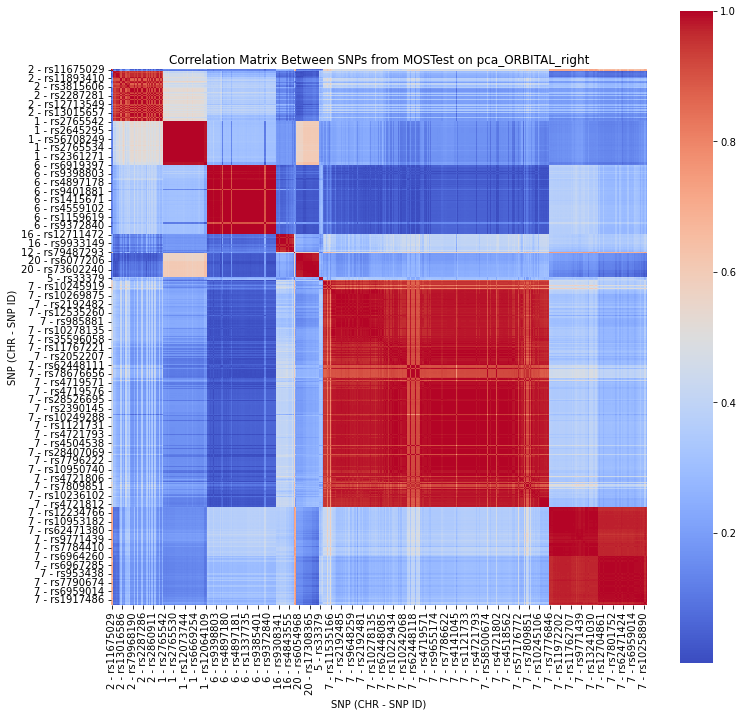

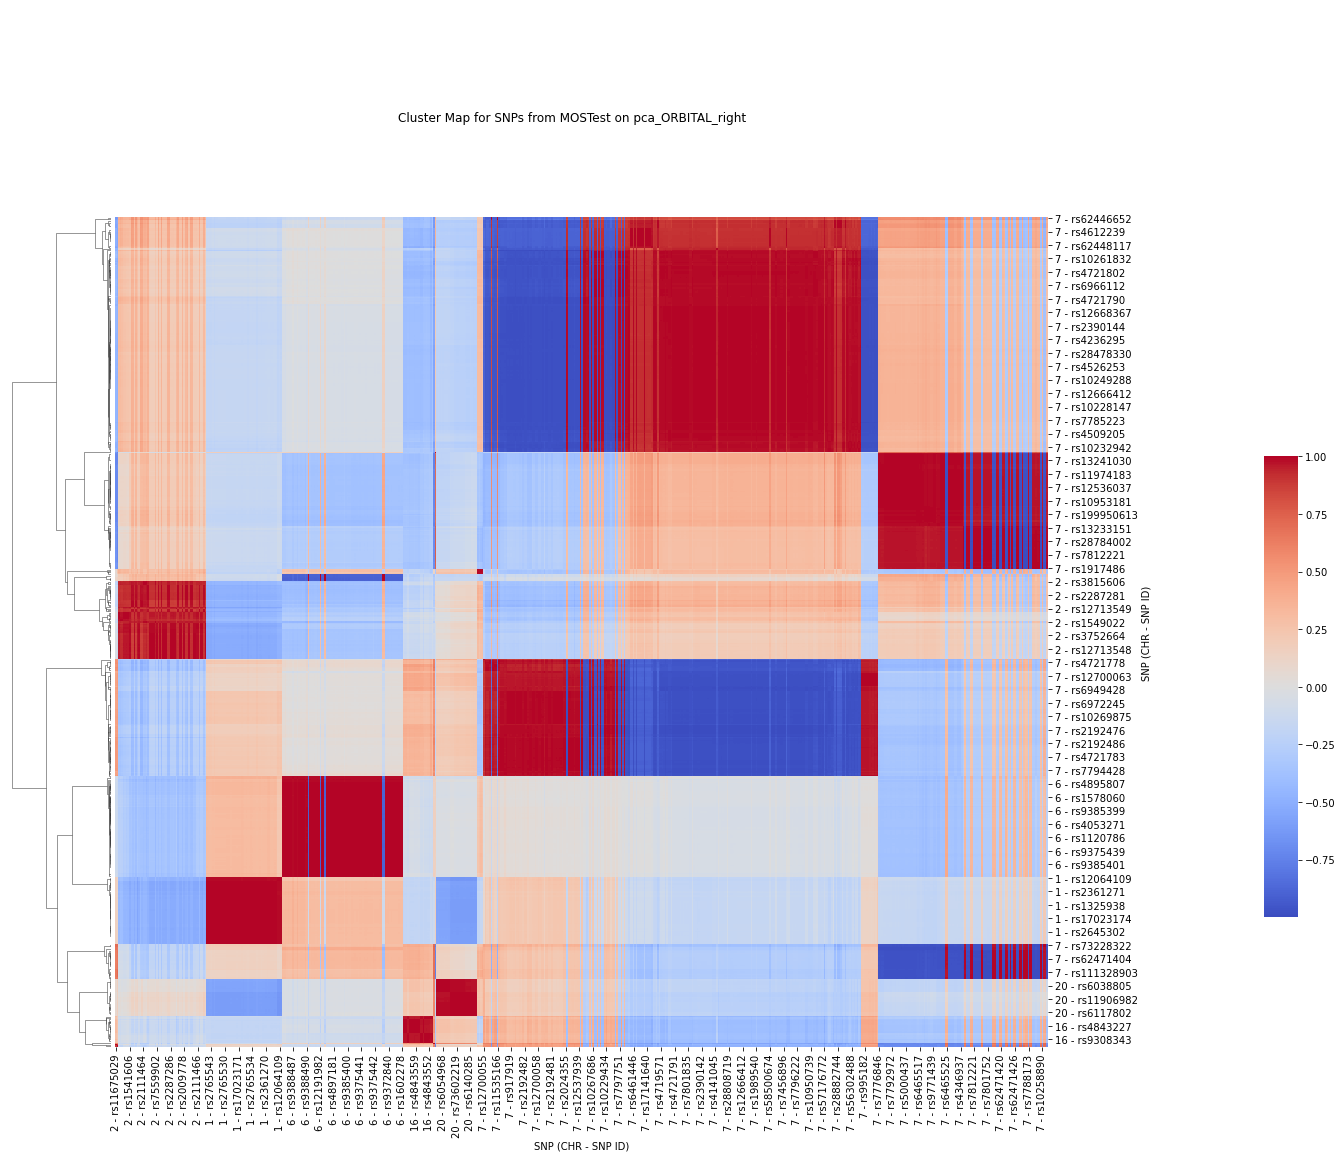



There are 23 loci.
23
Set 1: {'2 - rs11675029'}
Set 2: {'2 - rs7579323'}
Set 3: {'2 - rs3752664', '2 - rs13016586', '2 - rs2860911', '2 - rs6743531', '2 - rs1030088', '2 - rs3752663', '2 - rs4671686', '2 - rs79968190', '2 - rs10168499', '2 - rs4671683', '2 - rs2287283', '2 - rs2009778', '2 - rs7580807', '2 - rs7600385', '2 - rs1541606', '2 - rs7570841', '2 - rs7576487', '2 - rs4671684', '2 - rs6546175', '2 - rs2287286', '2 - rs56213130', '2 - rs1861771', '2 - rs2287282', '2 - rs4233934', '2 - rs10198367', '2 - rs6546176', '2 - rs12713548', '2 - rs7562708', '2 - rs11126056', '2 - rs2111466', '2 - rs10176894', '2 - rs888278', '2 - rs11126057', '2 - rs2193469'}
Set 4: {'2 - rs1549022', '2 - rs3856523', '2 - rs6745682', '2 - rs12989218', '2 - rs11893410', '2 - rs12997745', '2 - rs12465315', '2 - rs13015657', '2 - rs2193463', '2 - rs2111464', '2 - rs7591972', '2 - rs3815606', '2 - rs7562620', '2 - rs6546177', '2 - rs2193466', '2 - rs6709906', '2 - rs17681189', '2 - rs10203155', '2 - rs228

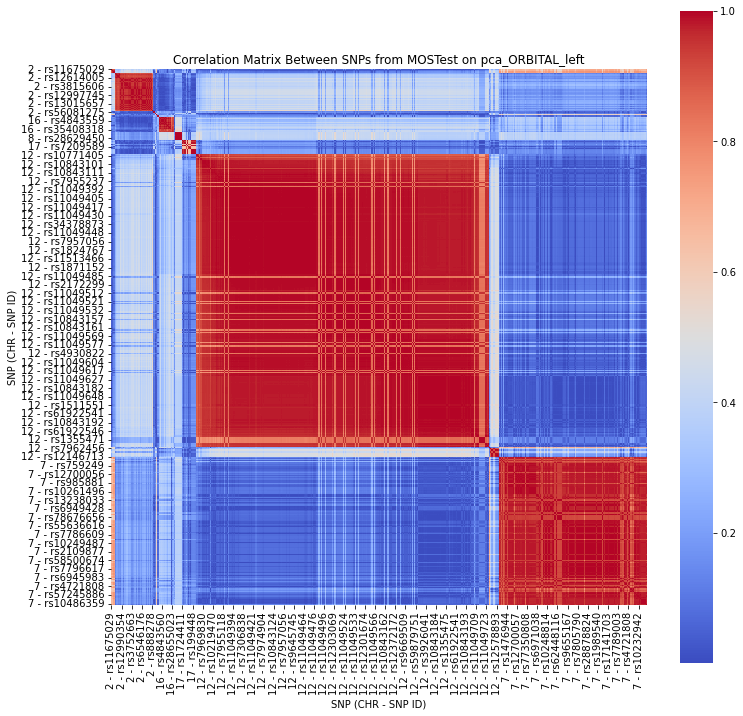

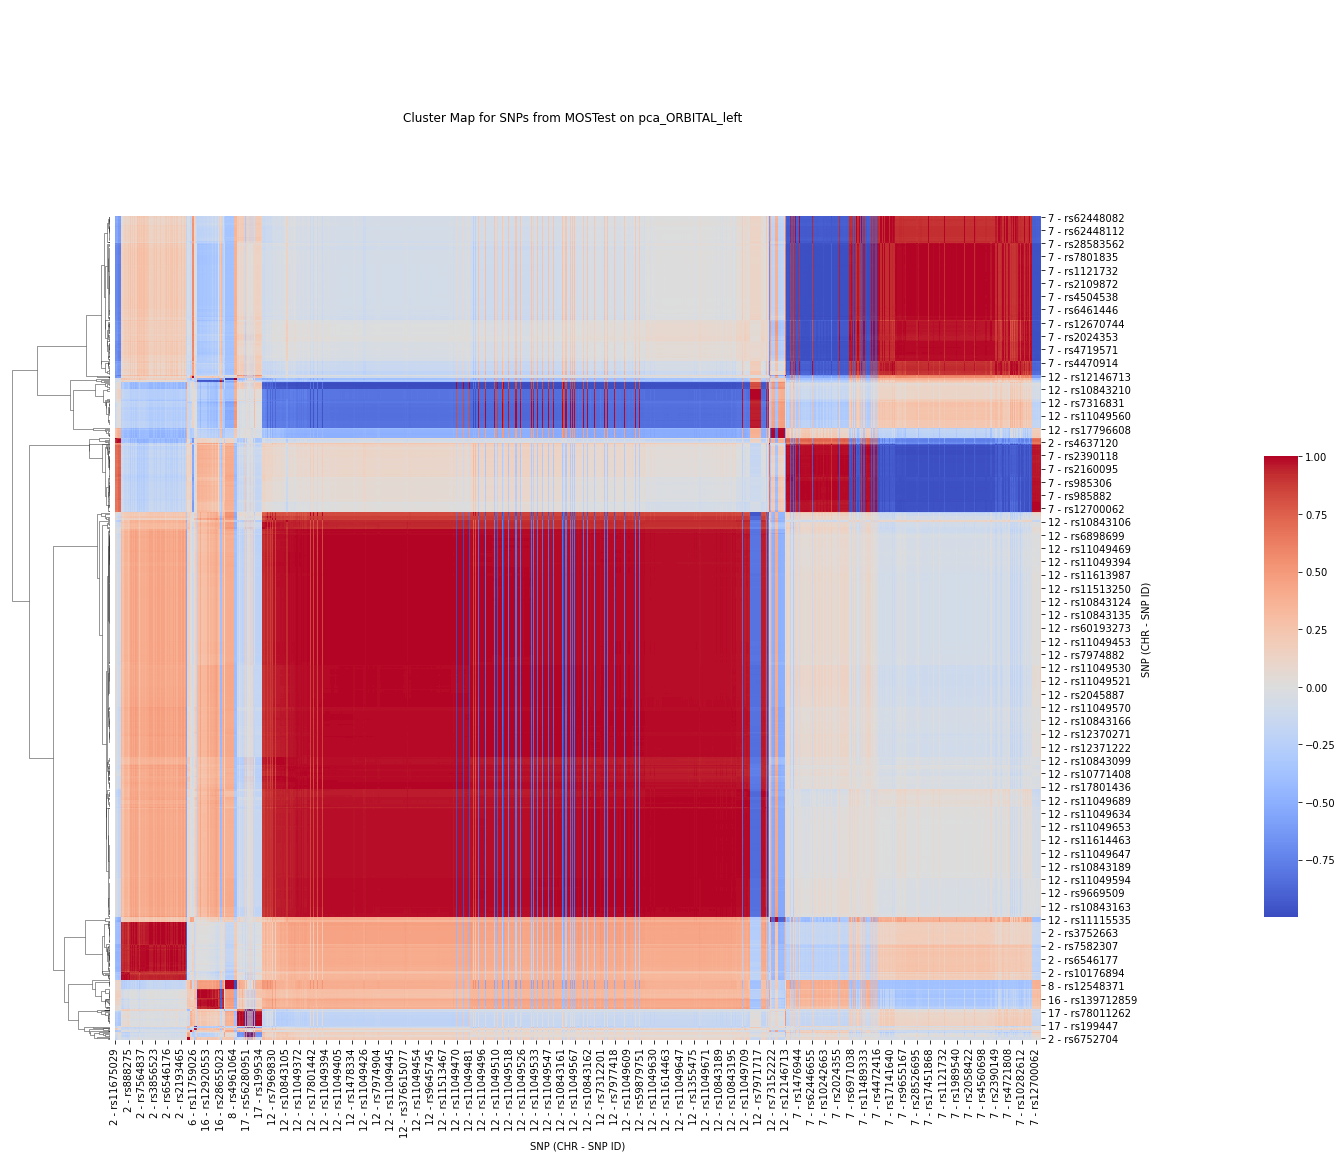



There are 45 loci.
45
Set 1: {'2 - rs11675029', '2 - rs4637120'}
Set 2: {'2 - rs4832603', '2 - rs7579323', '2 - rs11096542', '2 - rs4832605', '2 - rs7558413'}
Set 3: {'2 - rs4671684', '2 - rs11126056', '2 - rs2111466', '2 - rs888275', '2 - rs1861771', '2 - rs13016586', '2 - rs10176894', '2 - rs4671683', '2 - rs4233934', '2 - rs10198367', '2 - rs1541606', '2 - rs1030088', '2 - rs13028025', '2 - rs7576487', '2 - rs2193469', '2 - rs4671686', '2 - rs12713546'}
Set 4: {'2 - rs3752664', '2 - rs1549022', '2 - rs3815608', '2 - rs3856523', '2 - rs12989218', '2 - rs6745682', '2 - rs11893410', '2 - rs7559902', '2 - rs12997745', '2 - rs2860911', '2 - rs2193465', '2 - rs6743531', '2 - rs3752663', '2 - rs12465315', '2 - rs2287287', '2 - rs79968190', '2 - rs13008325', '2 - rs13015657', '2 - rs10168499', '2 - rs2287283', '2 - rs12713549', '2 - rs3815605', '2 - rs2009778', '2 - rs7580807', '2 - rs7600385', '2 - rs7570841', '2 - rs2193463', '2 - rs2111464', '2 - rs2287286', '2 - rs56213130', '2 - rs65

In [14]:
for region_name in list_region:

        print()
        print("###############################################################################################################")
        print()

        z_score = pd.read_csv(f'{path_to_most_results}/{region_name}_mostest_all_chr.most_orig.zmat.csv', sep='\t')

        pre_residualized_bdd = pd.read_csv(f'{path_to_most_results}/{region_name}_pheno_pre_residualized.txt', sep='\t')
        pre_residualized_bdd = pre_residualized_bdd.drop('#FID', axis=1)
        pre_residualized_bdd = pre_residualized_bdd.set_index('IID')
        #pre_residualized_bdd = pre_residualized_bdd[[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]

        correlation_matrix = Correlation_SNPs(z_score, region_name)

        Cluster_map_SNPs(z_score, region_name)

        print()
        print()

        correlated_sets = extract_highly_correlated_snps(correlation_matrix, threshold=corr_threshold)
        print(f'There are {len(correlated_sets)} loci.')
        print(len(correlated_sets))
        for idx, snp_set in enumerate(correlated_sets):
                if len(snp_set)>=1:
                        print(f"Set {idx + 1}: {snp_set}")
                        """snp_df = pd.DataFrame(list(snp_set), columns=['SNP'])
                        snp_df[['CHR', 'SNP']] = snp_df['SNP'].str.split(' - ', expand=True)
                        snp_df['CHR'] = snp_df['CHR'].astype(int)
        
                        #z_score = z_score[['CHR','SNP','PVAL']+[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]

                        # Now filter the z_score DataFrame
                        filtered_z_score = z_score[z_score['CHR'].isin(snp_df['CHR']) & z_score['SNP'].isin(snp_df['SNP'])]
                        
                        # Compute the average of each column, excluding 'CHR' and 'SNP'
                        average_values = filtered_z_score.drop(['CHR', 'SNP'], axis=1).mean()
                        
                        heriditary_direction = average_values.drop(['PVAL'], axis=0).to_numpy()
                        heriditary_direction = heriditary_direction.flatten()
                        sorted_projections = project(heriditary_direction, pre_residualized_bdd)

                        plot_figure(sorted_projections,pre_residualized_bdd, 100, snp_df['CHR'].astype(str).iloc[0], dim=len(average_values)-1)"""

        print()
        print("###############################################################################################################")
        print()